## Installing libraries that are not in collab

In [1]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 34.8 MB/s 
     |████████████████████████████████| 163 kB 59.0 MB/s 
     |████████████████████████████████| 7.6 MB 64.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")
!ls

Mounted at /content/gdrive
gdrive	sample_data  test_data.xlsx  train_data.xlsx


## Import Libraries
Importing the libraries that are required to perform operations on the dataset.

In [4]:
import json
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data preprocessing
Doing required processing of data.

In [5]:
df_train = pd.read_excel("train_data.xlsx")
df_test = pd.read_excel("test_data.xlsx")

In [6]:
df_train.head()

,text,intent
0,Hi,greeting
1,How are you,greeting
2,Good morning,greeting
3,Good afternoon,greeting
4,Good evening,greeting


In [7]:
df_test.head()

,text,intent
0,hello there,greeting
1,How is everything,greeting
2,Howâ€™s everything going,greeting
3,Good to see you,greeting
4,How you doing,greeting


In [8]:
len_labels = len(df_train.intent.unique())

In [9]:
df_train["intent"].value_counts()

course                    41
fees                      41
hostel                    41
scholarship               31
document                  28
syllabus                  28
creator                   28
name                      28
hours                     28
number                    28
goodbye                   28
infrastructure            28
event                     28
greeting                  27
location                  27
library                   25
transport                 25
canteen                   24
faculty                   23
sports                    21
medical                   20
salutation                19
admission                 19
ragging                   19
facilities                18
uniform                   18
college intake            17
fest                      17
random                    16
task                      15
notice                    13
placement                 13
menu                      13
hod                       12
principal     

In [10]:
df_test["intent"].value_counts()

greeting                  5
scholarship               5
uniform                   5
swear                     5
salutation                5
task                      5
ragging                   5
hod                       5
transport                 5
faculty                   5
admission                 5
student portal            5
faculty portal            5
sports                    5
fest                      5
university affiliation    5
medical                   5
college type              5
college intake            5
facilities                5
principal                 5
document                  5
name                      5
hours                     5
course                    5
fees                      5
location                  5
hostel                    5
event                     5
infrastructure            5
syllabus                  5
library                   5
canteen                   5
menu                      5
placement                 5
csehod              

In [11]:
# Converting the labels into encodings
le = LabelEncoder()
df_test['intent'] = le.fit_transform(df_test['intent'])
df_train['intent'] = le.fit_transform(df_train['intent'])

In [12]:
# check class distribution
df_train['intent'].value_counts(normalize = True)

4     0.047509
12    0.047509
17    0.047509
33    0.035921
7     0.032445
37    0.032445
5     0.032445
24    0.032445
18    0.032445
26    0.032445
14    0.032445
19    0.032445
8     0.032445
15    0.031286
21    0.031286
20    0.028969
39    0.028969
1     0.027810
10    0.026651
34    0.024334
22    0.023175
32    0.022016
0     0.022016
30    0.022016
9     0.020857
40    0.020857
2     0.019699
13    0.019699
31    0.018540
38    0.017381
25    0.015064
28    0.015064
23    0.015064
16    0.013905
29    0.011587
36    0.010429
35    0.010429
41    0.009270
11    0.008111
6     0.008111
3     0.005794
27    0.001159
Name: intent, dtype: float64

In [13]:
# check class distribution
df_test['intent'].value_counts(normalize = True)

15    0.025
33    0.025
40    0.025
36    0.025
32    0.025
38    0.025
30    0.025
16    0.025
39    0.025
10    0.025
0     0.025
35    0.025
11    0.025
34    0.025
13    0.025
41    0.025
22    0.025
3     0.025
2     0.025
9     0.025
29    0.025
7     0.025
24    0.025
18    0.025
4     0.025
12    0.025
21    0.025
17    0.025
8     0.025
19    0.025
37    0.025
20    0.025
1     0.025
23    0.025
28    0.025
6     0.025
25    0.025
31    0.020
26    0.020
14    0.015
5     0.015
27    0.005
Name: intent, dtype: float64

In [14]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df_train["text"], df_train["intent"]
test_text, test_labels = df_test["text"], df_test["intent"]


### Load Tokenizer

In [15]:
def load_tokenizer(model="bert"):
  tokenizer = None
  if model == "bert":
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
  if model == "roberta":
    # Load the Roberta tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
  if model == "distilbert":
    # Load the DistilBert tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  return tokenizer

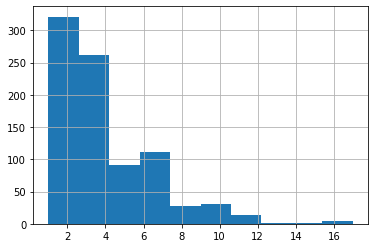

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

# Based on the histogram we are selecting the max len as 9
max_seq_len = 16

In [17]:
def get_tokenized_data(model="bert"):
  tokenizer = load_tokenizer(model=model)
  # tokenize and encode sequences in the training set
  tokens_train = tokenizer(
      train_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
                    )
  # tokenize and encode sequences in the testing set
  tokens_test = tokenizer(
      test_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
  )
  return tokens_train, tokens_test

In [18]:
tokens_train, tokens_test = get_tokenized_data("bert")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [20]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Setting Up models parameters

In [21]:
# Define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set and test set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Building our Lucy Model
To build lucy we are going to use pretrained Model and our own model.

### 1) Lucy layer

In [22]:
class Lucy(nn.Module):
  def __init__(self, pretrained_model):      
       super(Lucy, self).__init__()       
       self.pretrained_model = pretrained_model 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()     

       # dense layer       
       self.fc1 = nn.Linear(768,512)       
       self.fc2 = nn.Linear(512,256)       
       self.fc3 = nn.Linear(256,len_labels)    

       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)      
      
  #define the forward pass
  def forward(self, sent_id, mask):      
      #pass the inputs to the model  
      cls_hs = self.pretrained_model(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)      

      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)     
      return x

### 2) Pretrained layer + Lucy layer

In [23]:
def lucy_model(device,model="bert"):
  pretrained_model = None
  if model == "bert":
    # Import BERT-base pretrained model
    pretrained_model = AutoModel.from_pretrained("bert-base-uncased")

  if model == "roberta":
    # Import Roberta pretrained model
    pretrained_model = RobertaModel.from_pretrained("roberta-base")

  if model == "distilbert":
    # Import the DistilBert pretrained model
    pretrained_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

  # freeze all the parameters. This will prevent updating of model weights during fine-tuning.
  for param in pretrained_model.parameters():
        param.requires_grad = False

  lucy = Lucy(pretrained_model)

  # push the model to GPU or CPU
  lucy = lucy.to(device)

  return lucy

#### i) BERT

In [24]:
bert_model = lucy_model(device)
summary(bert_model)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

#### ii) Roberta

In [25]:
roberta_model = lucy_model(device, model="roberta")
summary(roberta_model)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                       Param #
Lucy                                                         --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (38,603,520)
│    │    └─Embedding: 3-2                                   (394,752)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                           

#### iii) DistilBert 

In [26]:
distilbert_model = lucy_model(device, model="distilbert")
summary(distilbert_model)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           10,794
├─LogSoftmax: 1-7                                       --
Total

In [27]:
# define the optimizer for BERT, Roberta, DistilBERT
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr = 1e-3)
roberta_optimizer = torch.optim.AdamW(roberta_model.parameters(), lr = 1e-3)
distilbert_optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr = 1e-3)

In [28]:
#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[ 1.08145363  0.85615079  1.20868347  4.10952381  0.50116144  0.73384354
  2.93537415  0.73384354  0.73384354  1.14153439  0.89337474  2.93537415
  0.50116144  1.20868347  0.73384354  0.76102293  1.71230159  0.50116144
  0.73384354  0.73384354  0.82190476  0.76102293  1.02738095  1.58058608
  0.73384354  1.58058608  0.73384354 20.54761905  1.58058608  2.0547619
  1.08145363  1.28422619  1.08145363  0.66282642  0.97845805  2.28306878
  2.28306878  0.73384354  1.36984127  0.82190476  1.14153439  2.56845238]


In [29]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [30]:
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [31]:
# empty lists to store training  loss of each epoch
train_losses=[]

# empty lists to store training  accuracy of each epoch
train_accuracies=[]

# number of training epochs
epochs = 500

In [32]:
# function to train the model
def train(dataloader, model, optimizer):
  
  model.train()
  total_loss = 0
  total_correct = 0
  
  # empty list to save model predictions
  total_preds=[]

   # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 15 batches.
    if step % 50 == 0 and not step == 0:
      print('Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # get model accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))
    
    total_correct += (p == labels.detach().cpu()).float().sum()


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clear calculated gradients
    optimizer.zero_grad()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  
  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)
 
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
  return avg_loss, avg_accuracy, total_preds
  
 

In [33]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_accuracy ,_ = train(train_dataloader, bert_model, bert_optimizer)
    
    # append training loss
    train_losses.append(train_loss)

    # appedn training accuracy
    train_accuracies.append(train_accuracy)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy * 100:.3f} %')


 Epoch 1 / 500
Batch    50  of     54.

Training Loss: 3.736

Training Accuracy: 4.171 %

 Epoch 2 / 500
Batch    50  of     54.

Training Loss: 3.550

Training Accuracy: 11.240 %

 Epoch 3 / 500
Batch    50  of     54.

Training Loss: 3.213

Training Accuracy: 18.888 %

 Epoch 4 / 500
Batch    50  of     54.

Training Loss: 2.871

Training Accuracy: 21.437 %

 Epoch 5 / 500
Batch    50  of     54.

Training Loss: 2.561

Training Accuracy: 29.664 %

 Epoch 6 / 500
Batch    50  of     54.

Training Loss: 2.349

Training Accuracy: 34.415 %

 Epoch 7 / 500
Batch    50  of     54.

Training Loss: 2.048

Training Accuracy: 42.526 %

 Epoch 8 / 500
Batch    50  of     54.

Training Loss: 1.820

Training Accuracy: 46.929 %

 Epoch 9 / 500
Batch    50  of     54.

Training Loss: 1.620

Training Accuracy: 52.144 %

 Epoch 10 / 500
Batch    50  of     54.

Training Loss: 1.476

Training Accuracy: 55.504 %

 Epoch 11 / 500
Batch    50  of     54.

Training Loss: 1.376

Training Accuracy: 59.444 

## Analysis of Training

In [34]:
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)

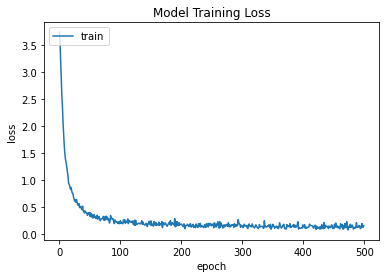

In [35]:
plt.plot(train_losses)
plt.title("Model Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("bert_model_loss.png")
plt.show()

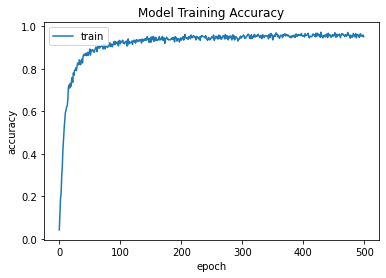

In [36]:
plt.plot(train_accuracies)
plt.title("Model Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("bert_model_accuracy.png")
plt.show()

## Saving the Lucy model

In [37]:
model_save_name = "lucy_bert.pth"
PATH = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(bert_model.state_dict(), PATH)

In [38]:
bert_model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

## Testing the Lucy

In [39]:
# empty lists to store testing  loss of each epoch
test_losses=[]

# empty lists to store tesing  accuracy of each epoch
test_accuracies=[]

In [40]:
@torch.no_grad()
def test(dataloader, model):
  total_loss = 0
  total_correct = 0
  
  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print("Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader))")

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    
    # compute the accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))
    
    total_correct += (p == labels.detach().cpu()).float().sum()

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)

  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions

  return avg_loss,avg_accuracy, total_preds
  
 

In [42]:
test_loss, test_accuracy , test_y_preds = test(test_dataloader, bert_model)

print(f'\nTesting Loss: {test_loss:.3f}')
print(f'\nTesting Accuracy: {test_accuracy * 100:.3f} %')


Testing Loss: 3.864

Testing Accuracy: 14.832 %


In [43]:
test_y_preds = np.argmax(torch.tensor(test_y_preds), axis=-1)

In [44]:
classes = le.classes_.tolist()

In [45]:
test_y_true = []
for batch in test_dataloader:
   _, _, labels = batch
   a = torch.Tensor.tolist(labels)
   for i in a:
     test_y_true.append(i)
  

In [46]:
test_y_true = le.inverse_transform(test_y_true)

In [47]:
test_y_preds = le.inverse_transform(test_y_preds)

In [48]:
# Classification report
classification_report(test_y_true, test_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                        precision    recall  f1-score   support\n\n             admission       0.71      1.00      0.83         5\n               canteen       0.60      0.60      0.60         5\n        college intake       1.00      0.80      0.89         5\n          college type       1.00      0.20      0.33         5\n                course       0.50      0.20      0.29         5\n               creator       1.00      0.67      0.80         3\n                csehod       0.40      0.40      0.40         5\n              document       0.67      0.40      0.50         5\n                 event       0.14      0.20      0.17         5\n            facilities       0.50      0.20      0.29         5\n               faculty       0.80      0.80      0.80         5\n        faculty portal       1.00      1.00      1.00         5\n                  fees       0.56      1.00      0.71         5\n                  fest       1.00      0.60      0.75         5\n               goodbye

In [49]:
# Build confusion matrix
cf_matrix = confusion_matrix(test_y_true, test_y_preds)

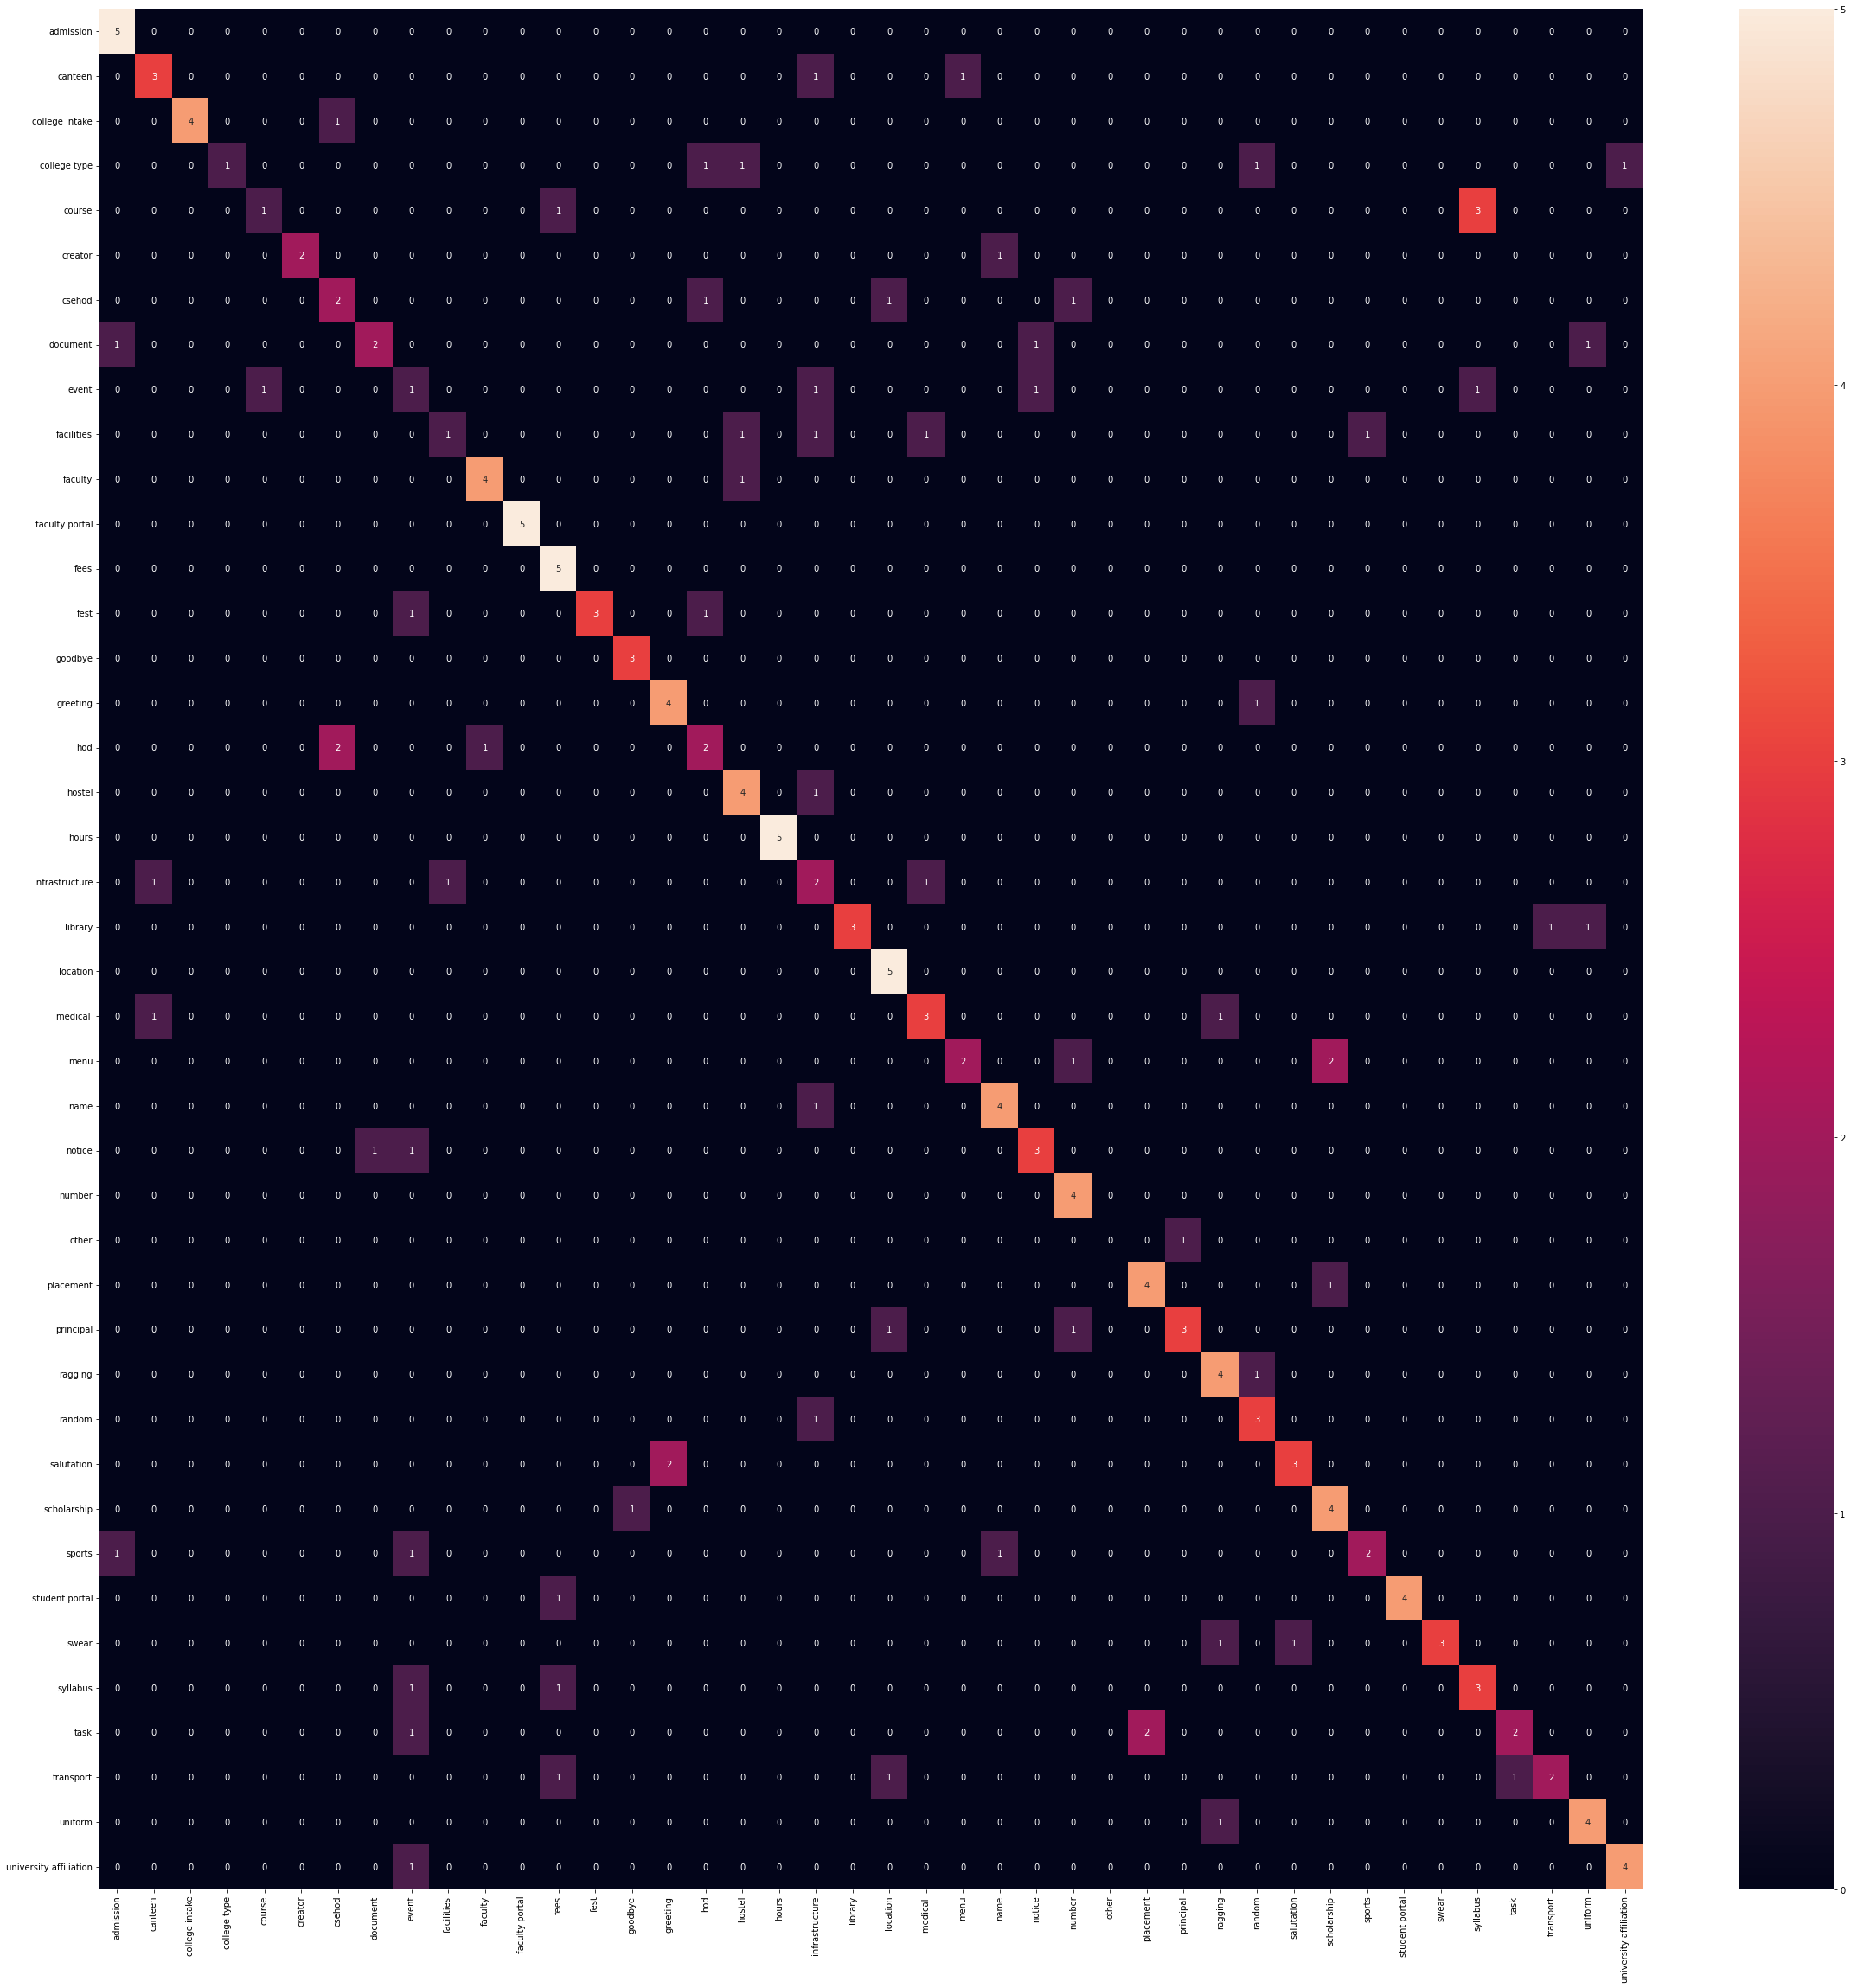

In [50]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (40,40))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix_roberta.png')

In [ ]:
import json

classes = le.classes_.tolist()
filename = 'labels.json'
with open(filename, 'w') as file_object:  
  json.dump(classes, file_object)